In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.integrate import odeint

def heat_eqn(eta,t,kt,h):
    return (kt*(np.diag(-2*np.ones(len(eta)),k=0)+ np.diag(np.ones(len(eta)-1),k=1) + np.diag(np.ones(len(eta)-1),k=-1))/(h**2))@eta

h = 0.05
L = 5
Kt = 0.5
t = np.linspace(0,10,200)
x = np.arange(-L/2,L/2,h)
eta0 = 10*np.exp(-(x)**2)
truth = odeint(heat_eqn,eta0,t,args=(Kt,h))


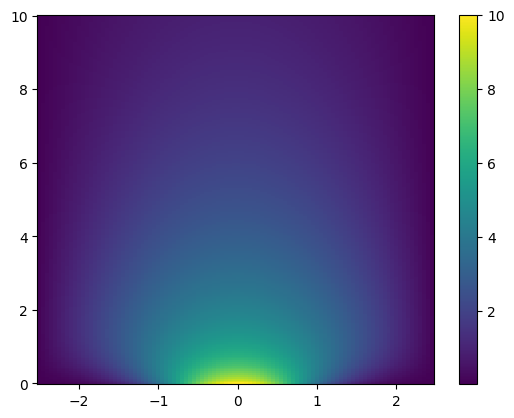

In [3]:
X,T = np.meshgrid(x,t)
plt.pcolormesh(X,T,truth)
plt.colorbar()

In [4]:
# lets add some noise
noisy_truth = truth + np.random.normal(loc=0,scale=0.5,size=truth.shape) ## IID noise

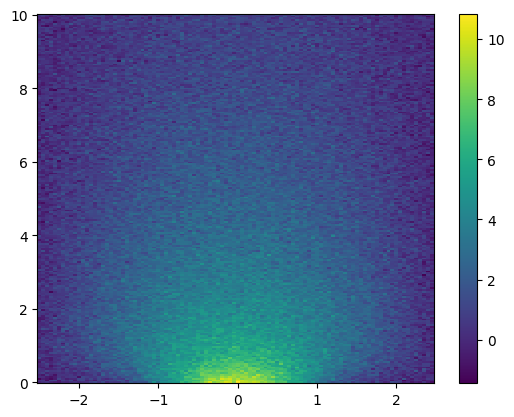

In [5]:
plt.pcolormesh(X,T,noisy_truth)
plt.colorbar()

### low rank approx

In [6]:
u,s,vh = np.linalg.svd(truth.T)

In [7]:
lowranktruth=np.sum([s[i]*np.outer(u[:,i],vh[i]) for i in range(1)],axis=0).T

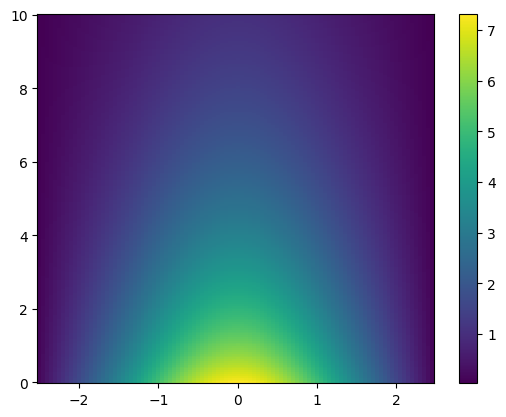

In [8]:
plt.pcolormesh(X,T,lowranktruth)
plt.colorbar()

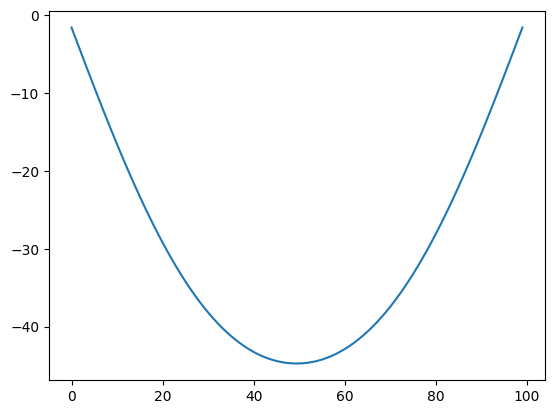

In [9]:
plt.plot(u[:,[0,1,2,3,4,5]]@s[[0,1,2,3,4,5]])

## PYSINDY

In [10]:
import pysindy as ps
library_function =  [lambda x: x, lambda x:x*x]
library_function_names = [lambda x: x, lambda x: x + x]
dt = t[1] - t[0]
truth_rshp = np.copy(truth.T.reshape(len(x),len(t),1))
pde_lib = ps.PDELibrary(
#     library_functions=library_functions,
#    library_functions=library_function,
#    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=False,
    include_interaction=False
)
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib,optimizer=optimizer,feature_names=['c'])
model.fit(truth_rshp,t=dt)
model.print()

(c)' = 0.500 c_11


### Try with Ben's Data

In [18]:
data = np.load('data_for_Rob_improved.npz')

In [19]:
csmean_c = data['concentration'][5:100,:]
unique_t = data['unique_t'][5:100]
unique_x = data['unique_x']
t_mesh, x_mesh = np.meshgrid(unique_t, unique_x)

Text(0, 0.5, 'x')

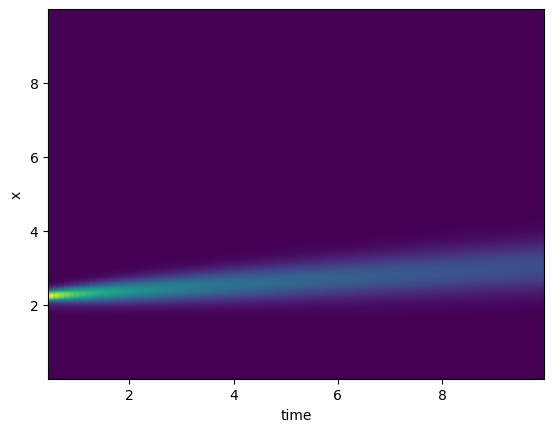

In [20]:
plt.pcolormesh(t_mesh,x_mesh,csmean_c.T)
plt.xlabel("time")
plt.ylabel("x")

In [21]:
sindy_conc = np.expand_dims(csmean_c.T,axis=-1)

In [22]:
import pysindy as ps
pde_lib = ps.PDELibrary(
    derivative_order=5,
    spatial_grid=x_mesh,
    is_uniform=True,
)
optimizer = ps.STLSQ(threshold=0.001, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib,optimizer=optimizer,feature_names=['c'])
model.fit(sindy_conc,t=unique_t)
model.print()

(c)' = -0.086 c_1 + 0.010 c_11


In [23]:
model.coefficients()

array([[-0.08562326,  0.00964544,  0.        ,  0.        ,  0.        ]])

In [17]:
csmean_c.shape

(95, 1024)